# MPA-MLF: Final project

Made by Dmitrii Semenov, Josef Pecka

Step 1: Import libraries

In [136]:
# Import general libraries
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Import main functions for ML
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.optimizers import Adamax
from keras.utils import to_categorical
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

# Import hyperparameter tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

# Import confusion matrix fucntion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set plot font 
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

Step 2: Load input files

In [137]:
# Set dataset paths
dataset_dir = ""
train_dir = os.path.join(dataset_dir, "Train")
test_dir = os.path.join(dataset_dir, "Test")
labels_path = os.path.join(dataset_dir, "label_train.csv")
test_format_path = os.path.join(dataset_dir, "test_format.csv")

# Load labels file and sort them in ascending order
labels_df = pd.read_csv(labels_path)
labels_df = labels_df.sort_values('ID').reset_index(drop=True)

# Prepare containers fro data
X = []
y = []

# Loop through each file ID
for _, row in labels_df.iterrows():
    file_name = f"{row['ID']}.npy"
    file_path = os.path.join(train_dir, file_name)
    try:
        sample = np.load(file_path)
        X.append(sample)
        y.append(row['target'])
    except Exception as e:
        print(f"[Error] Could not load {file_name}: {e}")

# Convert to NumPy arrays
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

print(f"[INFO] Loaded {X.shape[0]} samples of shape {X.shape[1:]}")
print(f"[INFO] Max value of X data {np.max(X)}")
print(f"[INFO] Min value of X data {np.min(X)}")
print(y)


[INFO] Loaded 1491 samples of shape (72, 48)
[INFO] Max value of X data 76.52984619140625
[INFO] Min value of X data -66.49512481689453
[0 0 0 ... 0 0 0]


Step 3: Data preprocessing

In [138]:
def data_expand(dataset, labels, multiplier=2, std=3):

    '''
    Expands dataset using data augmentation with class weights analysis: expands class 0 to the required multiplier 
    and expands class 1 and 2 data to be comparable with class 0 (in terms of data volume)

    Input parameters:
    -- dataset: original training data
    -- labels: labels for the original training data
    -- multiplier: number of duplicates of class 0 with noise
    -- std: standart deviation of noise

    Outputs:
    -- Augmented dataset and labels
    '''

    class_0 = dataset[labels == 0]
    class_1 = dataset[labels == 1]
    class_2 = dataset[labels == 2]

    print("Initial statistics")
    print("class_0:", class_0.shape[0], "\nclass_1:", class_1.shape[0], "\nclass_2:", class_2.shape[0], "\n")
    
    # Expand class 0
    for k in range(multiplier):
        class_0_aug = class_0 + np.random.normal(0, std, class_0.shape)
        dataset = np.append(dataset, class_0_aug, 0)
        labels = np.append(labels, np.zeros(class_0.shape[0]))
        
    N_class_0 = np.count_nonzero(labels == 0)

    # Expand class 1
    print("Expanding class_1 by:", N_class_0 // class_1.shape[0])
    for k in range(N_class_0 // class_1.shape[0]):
        class_1_aug = class_1 + np.random.normal(0, std, class_1.shape)
        dataset = np.append(dataset, class_1_aug, 0)
        labels = np.append(labels, np.ones(class_1.shape[0]))

    # Expand class 2
    print("Expanding class_2 by:", N_class_0 // class_2.shape[0])
    for k in range(N_class_0 // class_2.shape[0]):
        class_2_aug = class_2 + np.random.normal(0, std, class_2.shape)
        dataset = np.append(dataset, class_2_aug, 0)
        labels = np.append(labels, 2 * np.ones(class_2.shape[0]))    

    print("\nExpanded dataset")
    print("class_0:", np.count_nonzero(labels == 0), "\nclass_1:", np.count_nonzero(labels == 1), "\nclass_2:", np.count_nonzero(labels == 2), "\n")
    print("Final size of dataset:", dataset.shape)
    print("Final size of labels:", labels.shape)

    return dataset, labels

Data augmentation

In [139]:
# Print result
print(f"X_train shape: {X.shape}, X_val shape: {X.shape}")
print(f"y_train shape: {y.shape}, y_val shape: {y.shape}")

# Expand the data (augmentation)
X, y = data_expand(X, y, 1, 3)

X_train shape: (1491, 72, 48), X_val shape: (1491, 72, 48)
y_train shape: (1491,), y_val shape: (1491,)
Initial statistics
class_0: 1209 
class_1: 141 
class_2: 141 

Expanding class_1 by: 17
Expanding class_2 by: 17

Expanded dataset
class_0: 2418 
class_1: 2538 
class_2: 2538 

Final size of dataset: (7494, 72, 48)
Final size of labels: (7494,)


Data preprocessing - normalization, division into training and validation datasets

In [140]:
# Z-score normalization
X = X.astype("float32")
X_mean = X.mean()
X_std = X.std()
X = (X - X_mean) / X_std

print(f"[INFO] Mean value of data after Z-score normalization: {np.mean(X)}")

# Reshape for CNN input
X = X.reshape((-1, 72, 48, 1))

# One-hot encode labels
NUM_CLASSES = 3
y = to_categorical(y, NUM_CLASSES)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y,
    test_size=0.2,
    stratify=y.argmax(axis=1),
    random_state=42
)

# Print result
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}, y_val shape: {y_val.shape}")

[INFO] Mean value of data after Z-score normalization: -2.7833294780066353e-07
X_train shape: (5995, 72, 48, 1), X_val shape: (1499, 72, 48, 1)
y_train shape: (5995, 3), y_val shape: (1499, 3)


Visualization of class distribution in training and validation sets

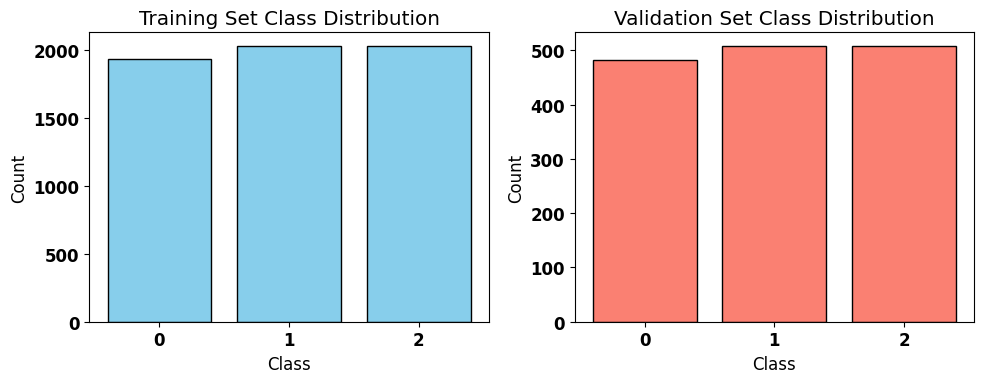

In [141]:
# Convert one-hot labels back to class indices
y_train_labels = y_train.argmax(axis=1)
y_val_labels = y_val.argmax(axis=1)

# Plot
plt.figure(figsize=(10, 4))

# Training set
plt.subplot(1, 2, 1)
plt.hist(y_train_labels, bins=np.arange(NUM_CLASSES + 1) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')
plt.xticks(range(NUM_CLASSES))
plt.title("Training Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

# Validation set
plt.subplot(1, 2, 2)
plt.hist(y_val_labels, bins=np.arange(NUM_CLASSES + 1) - 0.5, rwidth=0.8, color='salmon', edgecolor='black')
plt.xticks(range(NUM_CLASSES))
plt.title("Validation Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

Step 4: CNN model definition with tunable parameters and their ranges

In [142]:
'''
CNN model structure:
-- Input layer, shape (72,48,1)
-- Compulsory 1st convolutional layer
-- MaxPooling2D
-- Optional 2nd convolutional layer
-- MaxPooling2D
-- Optional 3rd convolutional layer
-- MaxPooling2D
-- Flatten
-- 1st Dense layer
-- 2nd Dense layer
-- Output layer
'''

def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(Input(shape = (72,48,1)))

    # Conv layer 1
    model.add(Conv2D(
        filters=hp.Choice("filters_1", [64, 128, 256]),
        kernel_size=hp.Choice("kernel_size_1", [3, 5]),
        activation='relu',
        input_shape=(72, 48, 1)
    ))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Optional Conv layer 2
    if hp.Boolean("add_conv_2"):
        model.add(Conv2D(
            filters=hp.Choice("filters_2", [64, 128, 256]),
            kernel_size=hp.Choice("kernel_size_2", [3, 5]),
            activation='relu'
        ))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Optional Conv layer 3
    if hp.Boolean("add_conv_3"):
        model.add(Conv2D(
            filters=hp.Choice("filters_3", [64, 128, 256]),
            kernel_size=hp.Choice("kernel_size_3", [3, 5]),
            activation='relu'
        ))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    
    # 1st Dense layer
    model.add(Dense(
        units=hp.Choice("dense_units", [64, 128, 256]),
        activation='relu'
    ))

    # Hyperparameter - dropout
    model.add(Dropout(rate=hp.Float("dropout", 0.2, 0.5, step=0.1)))

    # 2nd Dense layer
    model.add(Dense(
        units=hp.Choice("dense_units", [16, 32, 64]),
        activation='relu'
    ))

    # Output layer
    model.add(Dense(3, activation="softmax"))

    # Compilation options
    model.compile(
        optimizer=keras.optimizers.Adamax(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling='log')),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

Step 5: Run Keras Tuner to Find the Best Hyperparameters


Custom EarlyStopping calback (monitors if "monitor" is above predefined threshold) - can be useful in cases when the model is too complex and need several steps to start up the actual training - EarlyStopping won't react before the predefined threshold is reached (0.5 for "val_accuracy" in this case)

In [143]:
'''
Custom EarlyStopping calback (monitors if "monitor" is above predefined threshold), only if "val_accuracy" > threshold enables 
EarlyStopping callback

Input parameters:
-- monitor: metric to be monitored for EarlyStopping callback
-- patience: number of steps with the same or worse metric before stopping
-- threshold: minimum value of metric for EarlyStopping callback activation
-- verbose: level of severity for log messages
'''
class EarlyStoppingWithThreshold(Callback):
    def __init__(self, monitor='val_accuracy', patience=5, threshold=0.5, verbose=1):
        super().__init__()
        self.monitor = monitor
        self.patience = patience
        self.threshold = threshold
        self.verbose = verbose
        self.wait = 0
        self.best = -np.inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return
        
        # Only start checking if threshold is passed
        if current < self.threshold:
            if self.verbose:
                print(f"Epoch {epoch + 1}: {self.monitor} below threshold {self.threshold:.2f}, skipping early stop check.")
            return
        
        if current > self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                if self.verbose:
                    print(f"\nEpoch {epoch + 1}: early stopping triggered. Best {self.monitor}: {self.best:.4f}")
                self.model.stop_training = True

Initialize the tuner

In [144]:
# Number of runs of tuner (tuner points)
runs = 10

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=runs,            # You can increase this for better results
    executions_per_trial=1,    # Runs per model setting
    directory='tuner_results',
    project_name='cnn_tuning'
)

# Tuner summary
tuner.search_space_summary()

Search space summary
Default search space size: 7
filters_1 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
kernel_size_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
add_conv_2 (Boolean)
{'default': False, 'conditions': []}
add_conv_3 (Boolean)
{'default': False, 'conditions': []}
dense_units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Run the tuner

In [145]:
# Configure tuner
tuner.search(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStoppingWithThreshold(monitor='val_accuracy', patience=5, threshold=0.5, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-4, verbose=1)
    ],
    verbose=2
)

# Show the results
tuner.results_summary()

# Run tuner
tuner.search()

Trial 10 Complete [00h 01m 41s]
val_accuracy: 0.9986657500267029

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 23m 32s
Results summary
Results in tuner_results/cnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
filters_1: 256
kernel_size_1: 5
add_conv_2: False
add_conv_3: False
dense_units: 128
dropout: 0.2
learning_rate: 0.001958975633214816
Score: 1.0

Trial 06 summary
Hyperparameters:
filters_1: 64
kernel_size_1: 3
add_conv_2: True
add_conv_3: False
dense_units: 256
dropout: 0.4
learning_rate: 0.0009302852433676885
filters_2: 64
kernel_size_2: 3
filters_3: 128
kernel_size_3: 5
Score: 1.0

Trial 08 summary
Hyperparameters:
filters_1: 128
kernel_size_1: 3
add_conv_2: False
add_conv_3: True
dense_units: 64
dropout: 0.30000000000000004
learning_rate: 0.004910100840508796
filters_2: 256
kernel_size_2: 3
filters_3: 256
kernel_size_3: 3
Score: 1.0

Trial 01 summary
Hyperparameters:
filters_1: 128
kernel_size_1: 5
ad

Take the best model (the easiest and with high accuracy), extract training data

In [146]:
# Get the best 5 models (to then compare)
top_trials = tuner.oracle.get_best_trials(num_trials=5)

# Build models and print parameter counts
param_counts = []
models = []

for i, trial in enumerate(top_trials):
    model = tuner.hypermodel.build(trial.hyperparameters)
    models.append(model)
    params = model.count_params()
    param_counts.append((i, params))
    print(f"Model {i+1} - Total trainable parameters: {params}")

# Pick the trial with the lowest param count
best_index, best_param_count = min(param_counts, key=lambda x: x[1])
best_trial = top_trials[best_index]
best_model = models[best_index]
print(f"Picked model {best_index + 1}")

Model 1 - Total trainable parameters: 1334403
Model 2 - Total trainable parameters: 759747
Model 3 - Total trainable parameters: 759619
Model 4 - Total trainable parameters: 233155
Model 5 - Total trainable parameters: 333379
Picked model 4


Step 6: Final training of the best model and evaluation

In [147]:
# Retrain the best model
history = best_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=20,
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStoppingWithThreshold(monitor='val_accuracy', patience=5, threshold=0.5 , verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    ]
)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.5213 - loss: 0.9270 - val_accuracy: 0.9026 - val_loss: 0.3203 - learning_rate: 9.1114e-04
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.8991 - loss: 0.2995 - val_accuracy: 0.9046 - val_loss: 0.3041 - learning_rate: 9.1114e-04
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9301 - loss: 0.1992 - val_accuracy: 0.9433 - val_loss: 0.1502 - learning_rate: 9.1114e-04
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9533 - loss: 0.1373 - val_accuracy: 0.9313 - val_loss: 0.2115 - learning_rate: 9.1114e-04
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9584 - loss: 0.1258 - val_accuracy: 0.9453 - val_loss: 0.1306 - learning_rate: 9.1114e-04
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9628 - loss: 0.1020 - val_accuracy: 0.9513 - val_loss: 0.1126 - learning_rate: 9.1114e-04
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/ste

Model summary

In [148]:
# Data about best model
print(best_model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 68, 44, 128)    │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 34, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 20, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 8, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 7, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       114,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 699,467 (2.67 MB)

 Trainable params: 233,155 (910.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 466,312 (1.78 MB)

None


Accuracy metrics

In [149]:
# Info about model accuracy
val_preds = best_model.predict(X_val)
val_pred_labels = val_preds.argmax(axis=1)
val_true_labels = y_val.argmax(axis=1)

print("Predicted label distribution:", np.bincount(val_pred_labels))
print("Actual label distribution:", np.bincount(val_true_labels))

# Check accuracy manually
manual_acc = np.mean(val_pred_labels == val_true_labels)
print(f"Manual validation accuracy: {manual_acc:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Predicted label distribution: [482 506 511]
Actual label distribution: [483 508 508]
Manual validation accuracy: 0.9980


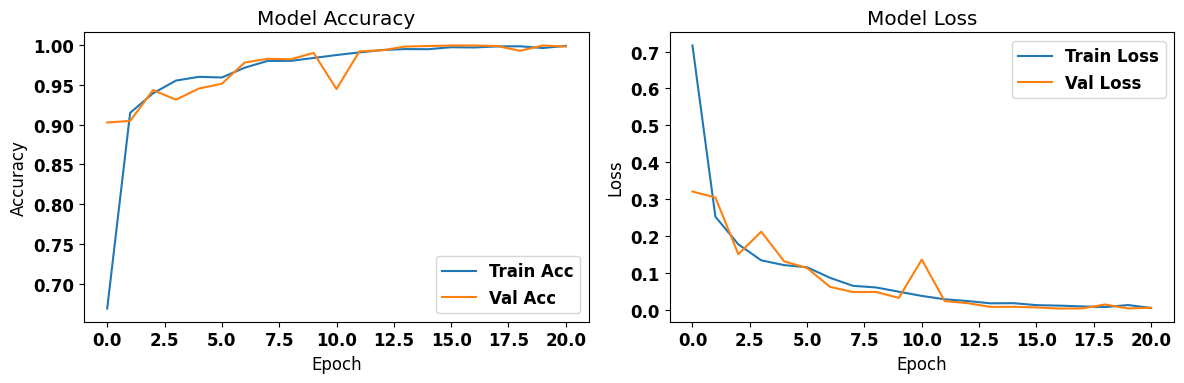

In [150]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Confusion matrix plotting

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


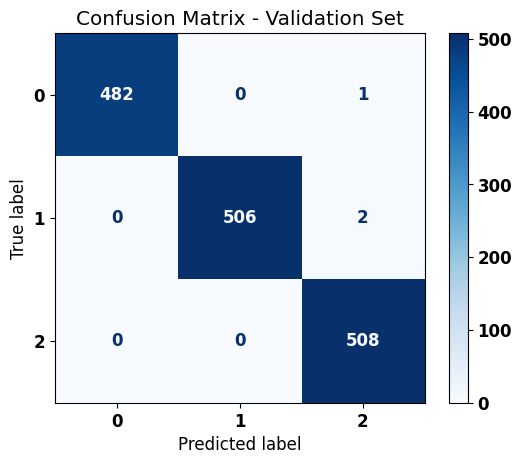

In [151]:
val_preds = best_model.predict(X_val)
val_pred_labels = val_preds.argmax(axis=1)
val_true_labels = y_val.argmax(axis=1)

# Compute and plot confusion matrix
cm = confusion_matrix(val_true_labels, val_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.show()

Step 7: Predictions on test set

In [152]:
# Load test filenames
test_format_path = os.path.join(dataset_dir, "test_format.csv")

# Load labels file and sort them to be in right order
test_labels_df = pd.read_csv(test_format_path)
tets_labels_df = test_labels_df.sort_values('ID').reset_index(drop=True)

# Prepare containers
X_test = []

# Loop through each file ID
for _, row in test_labels_df.iterrows():
    file_name = f"{row['ID']}.npy"
    #print(file_name)
    file_path = os.path.join(test_dir, file_name)
    try:
        sample = np.load(file_path)
        X_test.append(sample)
    except Exception as e:
        print(f"[Error] Could not load {file_name}: {e}")

X_test = np.array(X_test).astype("float32")

# Apply Z-score normalization using train mean/std
X_test = (X_test - X_mean) / X_std

# Reshape for CNN input
X_test = X_test.reshape((-1, 72, 48, 1))

print(f"Loaded {X_test.shape[0]} test samples")

Loaded 120 test samples


In [153]:
# Predict class probabilities
y_test_probs = best_model.predict(X_test)

# Convert to class labels (0, 1, 2)
y_test_pred = y_test_probs.argmax(axis=1)

# Preview
print("Predicted labels:", y_test_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted labels: [1 0 1 1 0 0 2 0 2 0 1 1 1 0 1 2 0 2 2 2 0 0 2 1 0 0 2 1 1 1 2 0 2 2 2 0 2
 0 0 0 1 2 1 0 1 2 1 0 2 1 1 0 2 0 0 1 0 1 2 0 2 1 1 2 1 1 2 1 0 2 1 1 2 2
 2 1 1 2 2 2 0 1 2 2 0 2 0 1 0 2 2 1 2 0 2 0 0 2 0 0 0 0 1 1 2 2 1 0 1 2 2
 0 1 1 0 1 2 0 0 1]


Step 8: Save Kaggle Submission File

In [154]:
# Load test_format.csv
test_format_path = os.path.join(dataset_dir, "test_format.csv")
submission_df = pd.read_csv(test_format_path)
submission_df = submission_df.sort_values('ID').reset_index(drop=True)

# Add predicted labels
submission_df["target"] = y_test_pred

# Save to CSV for Kaggle
submission_file = "submission.csv"
submission_df.to_csv(submission_file, index=False)

print(f"[INFO] Submission file saved: {submission_file}")
print(submission_df)

[INFO] Submission file saved: submission.csv
      ID  target
0      0       1
1      1       0
2      2       1
3      3       1
4      4       0
..   ...     ...
115  115       1
116  116       2
117  117       0
118  118       0
119  119       1

[120 rows x 2 columns]
